In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
def find_soil_saturation_period(precip_data, window_size=7, threshold_inches=8):
    """
    Find periods where the soil is likely saturated based on accumulated rainfall.
    
    Parameters:
    -----------
    precip_data : pandas.Series or numpy.ndarray
        Daily precipitation values in inches
    window_size : int, optional
        Number of days to consider for accumulated rainfall, default is 7 days
    threshold_inches : float, optional
        Minimum accumulated rainfall in inches over the window period to 
        consider soil saturated, default is 8 inches (203mm)
        
    Returns:
    --------
    list of int
        Indices where soil is considered saturated (end of the window period)
    """
    if isinstance(precip_data, pd.Series):
        precip_values = precip_data.values
    else:
        precip_values = precip_data
    
    saturation_indices = []
    
    # Find rolling sum of precipitation over the window
    for i in range(window_size-1, len(precip_values)):
        window_sum = sum(precip_values[i-window_size+1:i+1]) # forward looking window
        if window_sum >= threshold_inches:
            saturation_indices.append(i) # append last day in window
    
    return saturation_indices


In [27]:
def calculate_kbdi(precip_data, temp_data=None, initial_kbdi=None, max_kbdi=800, 
                   annual_rainfall=50, latitude=None, auto_initialize=True,
                   saturation_window=7, saturation_threshold=8):
    """
    Calculate the Keetch-Byram Drought Index (KBDI) from daily precipitation data.
    
    Parameters:
    -----------
    precip_data : pandas.Series or numpy.ndarray
        Daily precipitation values in inches
    temp_data : pandas.Series or numpy.ndarray, optional
        Daily mean temperature values in Fahrenheit
        If None, uses a default temperature of 70°F for all days
    initial_kbdi : float, optional
        Initial KBDI value (0-800), default is None which will trigger auto-initialization
        if auto_initialize is True, otherwise defaults to 0
    max_kbdi : float, optional
        Maximum possible KBDI value, default is 800
    annual_rainfall : float, optional
        Annual average rainfall in inches, default is 50 inches
    latitude : float, optional
        Latitude of the location in decimal degrees (used for temperature estimates if temp_data is None)
    auto_initialize : bool, optional
        If True, automatically find a saturated soil period to initialize KBDI as 0,
        default is True
    saturation_window : int, optional
        Number of days to look for soil saturation when auto-initializing, default is 7
    saturation_threshold : float, optional
        Inches of rain required in the saturation window to consider soil saturated,
        default is 8 inches (203mm)
        
    Returns:
    --------
    pandas.Series or numpy.ndarray
        KBDI values for each day
    """
    # Convert inputs to numpy arrays if they are pandas Series
    if isinstance(precip_data, pd.Series):
        dates = precip_data.index
        precip_data = precip_data.values
    # else:
    #     dates = pd.date_range(start='2023-01-01', periods=len(precip_data))
    
    if temp_data is None:
        # Use default temperature of 70°F if not provided
        # temp_data = np.full_like(precip_data, 70.0, dtype=float)
        pass
    elif isinstance(temp_data, pd.Series):
        temp_data = temp_data.values
    
    # Initialize KBDI array
    kbdi = np.zeros(len(precip_data))
    
    # Handle automatic initialization
    start_idx = 0
    if auto_initialize:
        # Find periods of soil saturation for initialization
        saturation_indices = find_soil_saturation_period(
            precip_data, window_size=saturation_window, threshold_inches=saturation_threshold
        )
        
        if saturation_indices:
            # Start calculation from the first saturation point
            start_idx = saturation_indices[0] + 1
            print(f"Auto-initialization: Found saturated soil at index {start_idx-1}, "
                  f"starting calculation from {start_idx}")
            # Set all previous values to None or NaN to indicate they're invalid
            kbdi[:start_idx] = np.nan
            # Set the value at the saturation point to 0
            if start_idx > 0:
                kbdi[start_idx-1] = 0
        else:
            print("Warning: No soil saturation period found for initialization. "
                  "Using manual initial_kbdi value or defaulting to 0.")
    
    # Set initial value
    # if initial_kbdi is not None:
    #     if np.isnan(kbdi[start_idx]):
    #         kbdi[start_idx] = initial_kbdi
    # else:
    #     if np.isnan(kbdi[start_idx]):
    #         kbdi[start_idx] = 0  # Default to 0 if not specified
    
    # Calculate KBDI for each day
    for i in range(start_idx + 1, len(precip_data)):
        # Get previous day's KBDI
        previous_kbdi = kbdi[i-1]
        
        # Skip calculation if previous value is NaN
        if np.isnan(previous_kbdi):
            kbdi[i] = np.nan
            continue
        # Get previous day's KBDI
        previous_kbdi = kbdi[i-1]
        
        # Step 1: Apply drought factor
        mean_temp = temp_data[i-1]  # Previous day's temperature
        
        # Calculate drought factor based on Keetch and Byram formula
        # The drought factor represents the rate of moisture loss
        if previous_kbdi <= 0:
            drought_factor = 0
        else:
            drought_factor = (0.968 * np.exp(0.0486 * mean_temp) - 8.3) * \
                            (max_kbdi - previous_kbdi) / 1000.0 * (1 + (10.88 * np.exp(-0.0441 * annual_rainfall)))
            
            # Ensure drought factor is non-negative
            drought_factor = max(0, drought_factor)
        
        # Step 2: Apply net rainfall effect
        # Net rainfall is the amount that effectively reduces the KBDI
        daily_precip = precip_data[i]
        
        if daily_precip > 0.2:
            # Only rainfall amounts above 0.2 inches affect the index
            net_rainfall = 10 * (daily_precip - 0.2)
        else:
            net_rainfall = 0
        
        # Step 3: Update KBDI
        new_kbdi = previous_kbdi + drought_factor - net_rainfall
        
        # Ensure KBDI stays within bounds
        new_kbdi = max(0, min(max_kbdi, new_kbdi))
        
        kbdi[i] = new_kbdi
    
    # Return result as pandas Series if input was a Series
    if dates is not None:
        result = pd.Series(kbdi, index=dates)
        # For pandas Series, we can handle NaN values properly
        if auto_initialize and start_idx > 0:
            # Keep only valid data starting from the initialization point
            result = result.dropna()
        return result
    return kbdi

In [28]:
def plot_kbdi(dates, kbdi_values, precipitation=None, temp_data=None):
    """
    Plot KBDI values over time, optionally with precipitation data.
    
    Parameters:
    -----------
    dates : array-like
        Dates corresponding to KBDI values
    kbdi_values : array-like
        KBDI values to plot
    precipitation : array-like, optional
        Daily precipitation values to plot as bars
    temp_data : array-like, optional
        Daily temperature values to plot on secondary axis
    """
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot KBDI
    ax1.plot(dates, kbdi_values, 'r-', label='KBDI')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('KBDI', color='r')
    ax1.tick_params(axis='y', labelcolor='r')
    ax1.set_ylim(bottom=0)
    
    # Add KBDI fire danger levels
    ax1.axhspan(0, 100, alpha=0.2, color='green', label='Low (0-100)')
    ax1.axhspan(100, 300, alpha=0.2, color='yellow', label='Moderate (100-300)')
    ax1.axhspan(300, 500, alpha=0.2, color='orange', label='High (300-500)')
    ax1.axhspan(500, 800, alpha=0.2, color='red', label='Extreme (500-800)')
    
    # Plot precipitation if provided
    if precipitation is not None:
        ax2 = ax1.twinx()
        ax2.bar(dates, precipitation, width=1.0, alpha=0.3, color='b', label='Precipitation')
        ax2.set_ylabel('Precipitation (inches)', color='b')
        ax2.tick_params(axis='y', labelcolor='b')
        ax2.invert_yaxis()  # Invert y-axis for precipitation
        ax2.set_ylim(top=0)  # Set top limit to 0
        
        # Add temperature if provided
        if temp_data is not None:
            ax3 = ax1.twinx()
            ax3.spines["right"].set_position(("axes", 1.1))
            ax3.plot(dates, temp_data, 'g-', label='Temperature')
            ax3.set_ylabel('Temperature (°F)', color='g')
            ax3.tick_params(axis='y', labelcolor='g')
            
            handles1, labels1 = ax1.get_legend_handles_labels()
            handles2, labels2 = ax2.get_legend_handles_labels()
            handles3, labels3 = ax3.get_legend_handles_labels()
            fig.legend(handles1 + handles2 + handles3, labels1 + labels2 + labels3, 
                      loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=3)
        else:
            handles1, labels1 = ax1.get_legend_handles_labels()
            handles2, labels2 = ax2.get_legend_handles_labels()
            fig.legend(handles1 + handles2, labels1 + labels2,
                      loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=3)
    else:
        plt.legend(loc='best')
    
    plt.title('Keetch-Byram Drought Index (KBDI) Over Time')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return fig



In [25]:
# pr_df = pd.read_csv('../test_data/nclimgrid-d_pr_singlegrid_1951-1952.csv',index_col='time')
# t_df = pd.read_csv('../test_data/nclimgrid-d_tmax_singlegrid_1951-1952.csv',index_col='time')

precip_series = pd.read_csv('../test_data/nclimgrid-d_pr_inches_singlegrid_1951-1952.csv',parse_dates=['time'],index_col='time')['prcp']
temp_series = pd.read_csv('../test_data/nclimgrid-d_tmax_F_singlegrid_1951-1952.csv',index_col='time')#['tmax']
annual_pr = precip_series.groupby(precip_series.index.year).sum().mean()
annual_pr

np.float64(43.89809959)

Auto-initialization: Found saturated soil at index 87, starting calculation from 88


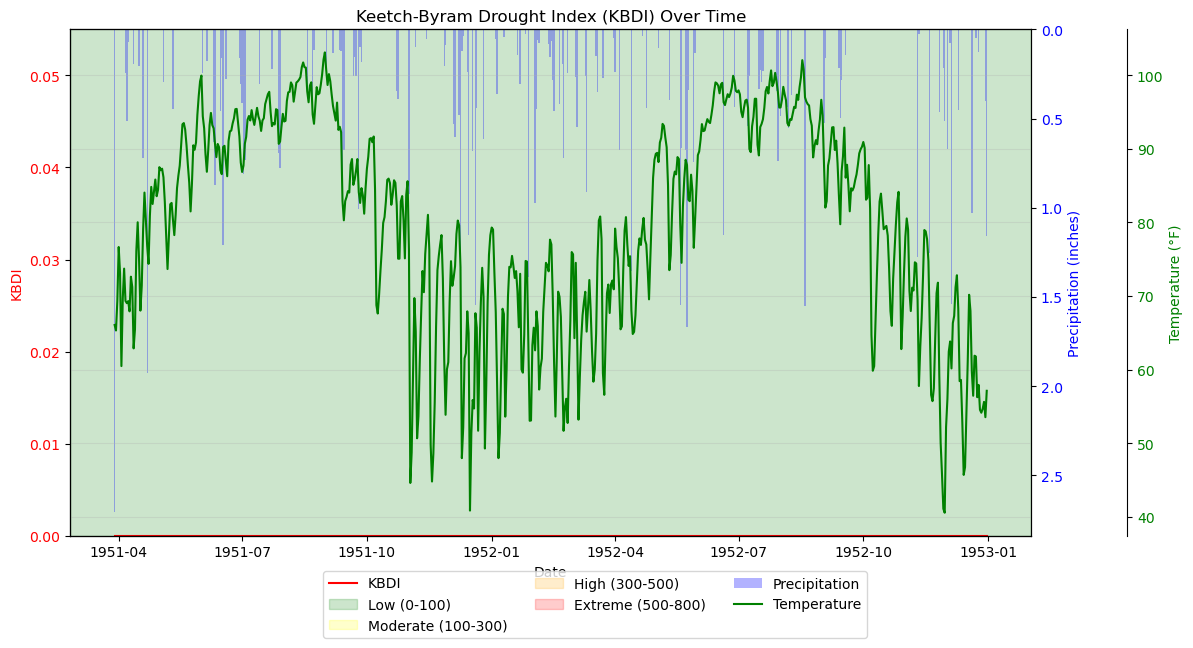

First valid KBDI date: 1951-03-29
Initial KBDI: 0.00
Final KBDI: 0.00
Maximum KBDI: 0.00 on 1951-03-29
Minimum KBDI: 0.00 on 1951-03-29


In [29]:
if __name__ == "__main__":
    # # Create sample data
    # num_days = 730  # Two years of data for better visualization
    # start_date = datetime(2023, 1, 1)
    # dates = [start_date + timedelta(days=i) for i in range(num_days)]
    
    # # Create synthetic precipitation data (more rain in spring/summer, less in fall/winter)
    # np.random.seed(42)
    # precip = np.zeros(num_days)
    # for i in range(num_days):
    #     month = (start_date + timedelta(days=i)).month
    #     # Summer months (higher chance of precipitation)
    #     if 4 <= month <= 9:
    #         if np.random.random() < 0.3:  # 30% chance of rain
    #             precip[i] = np.random.exponential(0.5)  # Random amount of rain
    #     else:  # Winter months (lower chance of precipitation)
    #         if np.random.random() < 0.15:  # 15% chance of rain
    #             precip[i] = np.random.exponential(0.3)  # Random amount of rain
    
    # # Create synthetic temperature data
    # temp = np.zeros(num_days)
    # for i in range(num_days):
    #     day_of_year = (dates[i] - datetime(dates[i].year, 1, 1)).days
    #     # Simple sinusoidal temperature model
    #     temp[i] = 60 + 25 * np.sin((day_of_year - 15) * 2 * np.pi / 365)
    #     # Add some noise
    #     temp[i] += np.random.normal(0, 5)
    
    # # Create pandas Series
    # precip_series = pd.Series(precip, index=pd.DatetimeIndex(dates))
    # temp_series = pd.Series(temp, index=pd.DatetimeIndex(dates))
    
    # # Add a synthetic heavy rainfall period to ensure auto-initialization works
    # # Add 10 inches of rain over 5 days at day 60
    # for i in range(5):
    #     precip_series.iloc[60+i] = 2.0

    precip_series = pd.read_csv('../test_data/nclimgrid-d_pr_inches_singlegrid_1951-1952.csv',parse_dates=['time'],index_col='time')['prcp']
    temp_series = pd.read_csv('../test_data/nclimgrid-d_tmax_F_singlegrid_1951-1952.csv',parse_dates=['time'],index_col='time')['tmax']
    annual_pr = precip_series.groupby(precip_series.index.year).sum().mean()


    # Calculate KBDI with auto-initialization
    kbdi_values = calculate_kbdi(
        precip_series, 
        temp_series, 
        auto_initialize=True,
        saturation_window=7,
        saturation_threshold=6,
        annual_rainfall=annual_pr
    )
    
    # Plot results
    fig = plot_kbdi(kbdi_values.index, kbdi_values.values, 
                   precipitation=precip_series[kbdi_values.index], 
                   temp_data=temp_series[kbdi_values.index])
    plt.show()
    
    # Print some summary statistics
    print(f"First valid KBDI date: {kbdi_values.index[0].strftime('%Y-%m-%d')}")
    print(f"Initial KBDI: {kbdi_values.iloc[0]:.2f}")
    print(f"Final KBDI: {kbdi_values.iloc[-1]:.2f}")
    print(f"Maximum KBDI: {kbdi_values.max():.2f} on {kbdi_values.idxmax().strftime('%Y-%m-%d')}")
    print(f"Minimum KBDI: {kbdi_values.min():.2f} on {kbdi_values.idxmin().strftime('%Y-%m-%d')}")
    
    # # Compare with manual initialization
    # kbdi_manual = calculate_kbdi(
    #     precip_series, 
    #     temp_series, 
    #     initial_kbdi=0,
    #     auto_initialize=False,
    #     annual_rainfall=40
    # )
    
    # print("\nComparison between auto-initialized and manually initialized KBDI:")
    # print(f"Auto-init first date: {kbdi_values.index[0].strftime('%Y-%m-%d')}")
    # print(f"Auto-init last date: {kbdi_values.index[-1].strftime('%Y-%m-%d')}")
    # print(f"Auto-init final KBDI: {kbdi_values.iloc[-1]:.2f}")
    # print(f"Manual-init final KBDI: {kbdi_manual.iloc[-1]:.2f}")
    # print(f"Difference: {abs(kbdi_values.iloc[-1] - kbdi_manual.iloc[-1]):.2f}")